nodes.shape=(1, 10, 10, 2)
B_k=array([0, 0])


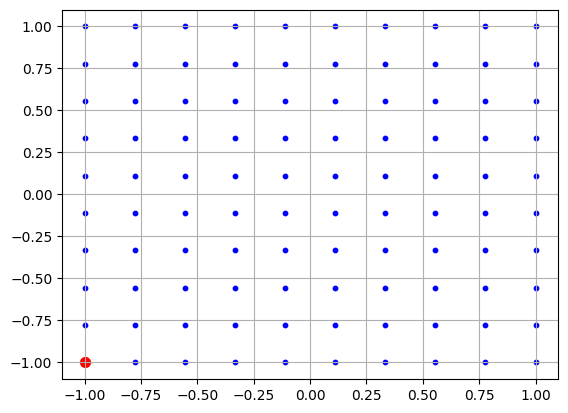

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 1
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 10
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
depots_i = np.array([[0, 0]])
## Four depot nodes (one in each corner)
# depots_i = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])

# Chose starting depot node
B_k = depots_i[0]
print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depots_i[:,0],depots_i[:,1],0], nodes[0,depots_i[:,0],depots_i[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [3]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = (1. + q_k) * np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
cost = cost.reshape((1,) + cost.shape)
cost = np.concatenate([cost for _ in range(k)], axis=0)
print(f"{cost.shape=}")


cost.shape=(1, 10, 10, 10, 10)


In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# Set the OBJECTIVE FUNCTION
# ((1+q_k) * c_{ij}) * x^{k}_{ij}
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=int(n*n-len(depots_i)), obj=cost)
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    is_depot_involved = False
    for depots_ii in depots_i:
        if (depots_ii[0] == i1 and depots_ii[1] == j1) or (depots_ii[0] == i2 and depots_ii[1] == j2):
            is_depot_involved = True
            # print((i1, j1, i2, j2))
            continue
    if is_depot_involved:
        continue
    _ = m.addConstr(x[:,i1,j1,i2,j2] <= 1)
# Above code handles A. Integer Constraints (4) and (5)


In [5]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
for i1, j1 in itertools.product(range(n), range(n)):
    is_depot_involved = False
    for depots_ii in depots_i:
        if depots_ii[0] == i1 and depots_ii[1] == j1:
            is_depot_involved = True
            continue
    if is_depot_involved:
        continue
    _ = m.addConstr(x[:,i1,j1,:,:].sum() == 1)
    _ = m.addConstr(x[:,:,:,i1,j1].sum() == 1)
# (8) and (9) Begin and end at same position B_k
_ = m.addConstrs(x[ki,B_k[0],B_k[1],:,:].sum() <= 1 for ki in range(k))
_ = m.addConstrs(x[ki,:,:,B_k[0],B_k[1]].sum() <= 1 for ki in range(k))
# (10) Every robot that visits a target leaves the target
_ = m.addConstrs(x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:] == 0 for ki in range(k) for i1 in range(n) for j1 in range(n))


In [6]:
# C. Degree Constraints (11), (12), (13), (14)
# This may be a lazy constraint because it is about sub tour elimination.
# C. Degree Constraints (11), (12), (13), (14)
# This may be a lazy constraint because it is about sub tour elimination.
p = m.addMVar((n,n,n,n), name='p', vtype=GRB.INTEGER)
#(11)
for ki in range(k):
    _ = m.addConstr((p[B_k[0], B_k[1], :, :] - p[:, :, B_k[0], B_k[1]]).sum() == x[ki,1:,1:,:,:].sum()) #this line will no longer work as intended if starting pos/depot is at a different position than [0,0]
#(12)
    _ = m.addConstr((p[i1, j1, :, :] - p[:, :, i1, j1]).sum() == x[ki,1:,1:,:,:].sum()) #this line will no longer work as intended if starting pos/depot is at a different position than [0,0]
#(13)
    for d in depots_i:
        _ = m.addConstr((p[:, :, d[0], d[1]] - p[d[0], d[1], :, :]).sum() == 0)

    _ = m.addConstrs(p[i1,j1,:,:] >= 0 for ki in range(k) for i1 in range(n) for j1 in range(n))
    _ = m.addConstrs(p[i1,j1,:,:] <= fuel_capacity*x[ki,i1,j1,:,:] for ki in range(k) for i1 in range(n) for j1 in range(n))
    
        for next in neighbors(current):
            new_cost = cost_so_far[current] + math.dist(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost #+ math.dist(next, (i2,j2))
                frontier.put(next, priority)
                came_from[next] = current
                
    curr_val = (i2, j2)
    final_path = []
    while curr_val != (i1, j1):
        final_path.append(curr_val)
        curr_val = came_from[curr_val]
            
    final_path.append((i1, j1))
    final_path.reverse()
    
    return final_path
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable
ri = model.addVar(1, name='ri', vtype=GRB.INTEGER)
rj = model.addVar(1, name='rj', vtype=GRB.INTEGER)

for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    fij = len(a_star_search(i1,j1,i2,j2))
    _ = model.addConstr(rj-ri+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,:,:])) #(15)
    _ = model.addConstr(rj-ri+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,:,:])) #(16)

    #(20)
    _ = model.addConstr(0<=ri)
    _ = model.addConstr(ri<=fuel_capacity)
    for depot in depots_i:
        if i1 == depot[0] and j1 == depot[1]:
            _ = model.addConstr(rj-fuel_capacity+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,depot[0],depot[1]])) #(17)
            _ = model.addConstr(rj-fuel_capacity+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,depot[0],depot[1]])) #(18)
        if i2 == depot[0] and j2 == depot[1]:
            _ = model.addConstr(ri-fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,depot[0],depot[1],i2,j2])) #(19)

In [7]:
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable

from queue import PriorityQueue
import math
import itertools
#https://www.redblobgames.com/pathfinding/a-star/implementation.html#python-astar
def neighbors(curr):
    ns = [(curr[0]+1, curr[1]), (curr[0]-1, curr[1]), (curr[0], curr[1]+1), (curr[0], curr[1]-1), (curr[0]+1, curr[1]+1), (curr[0]-1, curr[1]-1), (curr[0]+1, curr[1]-1), (curr[0]-1, curr[1]+1)]
    neighbors = []
    for n in ns:
        if n[0] <= 9 and n[0] >= 0 and n[1] <= 9 and n[1] >= 0:    
            neighbors.append(n)
    return neighbors

#there are absolutely better ways to do this, this is just the one that took me 10 minutes to do.
def a_star_search(i1, j1, i2, j2):
    frontier = PriorityQueue()
    frontier.put((i1,j1), 0)
    came_from = dict()
    cost_so_far = dict()
    came_from[(i1,j1)] = None
    cost_so_far[(i1,j1)] = 0
    
    
    while not frontier.empty():
        current = frontier.get()
        if current == (i2, j2):
            break


In [8]:
#V.A Cost Adjustment
def shortest_path(i1,j1,i2,j2):
   #DIJKSTRA
    
def cost_adjustment():
  for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
      if [i1, j1] != [i2, j2]:
          #Ci = min(cost from each depot to i)
          #Bj = min(cost from j to each depot)
          #cij <= fuel - Ci - Bj
            #n_cij = cij
          #else:
            #Pij = shortest path from node 1 to depot to node 2
            #cost[i1,j1,i2,j2] = len(Pij)
          #


SyntaxError: incomplete input (3701877660.py, line 11)

In [ ]:
#V.B: Suboptimal Hamiltonian Path

#Kruskal's Algorithm to find Minimum Spanning Tree (MST) of a graph:
#(1) sort all node connections by weight
#(2) choose smallest
        #if forms cycle, discard
        #else, add to list
     #repeat (2) until (# of nodes - 1) edges in the tree

#returns MST based on Kruskal's algorithm
def Kruskal_MST():
    
#paper's v of Christophides Algorithm:
#(1) construct MST based on Kruskal's Algorithm
#(2) graph (nodes+edges) G = MST U {start node, goal node}, cost from start node in MST to node = 0, same for goal, cost from start to goal node is infinite
#(3) O = all nodes in G w/ odd number of vertices
#(4) find minimum cost perfect matching (minimum possible cost graph where every node appears exactly once) M on O
#(5) M U MST edges = Eulerian path, rm duplicate nodes and == Hamiltonian

#returns hamiltonian path based on Christophides
def Hamiltonian_planner():
    

In [1]:
#V.C: Splitting Algorithm

def split(path, edges):
    # removes edges from path, returns set of subpaths

#takes in graph of edges, number to split to 
#returns n set of resulting paths
def splitting(graph, n):
#Lcrit = len(Hamiltonian_planner())/(n # of robots/# of desired paths)
#e_sort = edges of Hamiltonian path H sorted by cost
#e_rem = {}
#S = []
#for k in range(1:n-1):
  #for ei in e_sort:
     #S = S.append(split(H,e_rem U ei))
     #n_req = 0
     #for s in S:
       #n_req = n_req + max(len(s)/Lcrit, 1)
     #if n_req <= n
       #e_sort = e_sort.remove(ei)
       #e_rem = e_rem.append(ei)
       #break
#return split(H, e_rem)

In [ ]:
#V.D assignment algorithm

def assignment()
  #run splitting() on all possible numbers of robots (1 - # of robots)
  #choose the one that accomplishes the task 'fastest' (implemented here as {TODO}) 

  #find cost matrix D of size (# of robots x # of tours) of the chosen one
  #cost = numpy.empty((len(robots), len(tours)))
  #B = starting position (?)
  #A = list of paths
  #for i in robots:
     #for j in tours:
       #cost = length of going from starting position of robot to starting position of tour + length of tour + length of going from ending position of tour to starting position of robot
  #use hungarian algorithm to find best option based on cost matrix

In [ ]:
#V.E Strand Check

#take your tours from above, turn into strands (except this is already done for us, because we only have one depot)
#add going to depot detours in between every target
#rm greedily until you can't remove any more
